# Imports and Data loading

In [528]:
######### List of imports ################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from ThymeBoost import ThymeBoost as tb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose

###########################################

######### Models to consider ############
# 1. GBRT
# 2. LSTM - Recurrent NN (both feedforward and feedback)
# 3. LightGBM - Efficient GBRT with feature building
# 4. Elastic Net
# 5. ARIMA
#######################################

In [15]:
## Read data from "BTCUSD"

data = pd.read_csv("/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/raw_data.csv")

In [25]:
data.head()

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,NaN
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07


# Feature Creation

In [17]:
# Weighted Average Price 
data['WAP'] = (data['bids_price_01']*data['bids_size_01']
               +data['bids_price_02']*data['bids_size_02']
               +data['ask_price_01']*data['ask_size_01']
               +data['ask_price_02']*data['ask_size_02'])/(data['bids_size_01']+
                                         data['bids_size_02']+
                                         data['ask_size_01']+
                                         data['ask_size_02'])

In [19]:
## Spread
data['spread'] = ((data['ask_price_01']/data['bids_price_01']) - 1)

In [24]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [29]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [30]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)

In [38]:
y = data['realized_volatility'].to_frame()

In [40]:
## Create a copy of data named df
df = data

In [42]:
## Drop the target y
df.drop(['realized_volatility'], axis = 1, inplace = True) 

In [45]:
## Check if two roles have the same value
df.duplicated().value_counts()

False    7263
dtype: int64

In [47]:
df

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,NaN,NaN
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274


# Deal with Missing Data

In [48]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(df[['volatility_t+1']]) # Call the "fit" method on the object

df['volatility_t+1'] = imputer.transform(df[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [55]:
imputer2 = SimpleImputer(strategy="constant", fill_value = df.iloc[1,13])

imputer2.fit(df[['log_returns']]) # Call the "fit" method on the object

df['log_returns'] = imputer2.transform(df[['log_returns']]) # Call the "transform" method on the object

imputer2.statistics_ # The mean is stored in the transformer's memory

array([2.38511078e-09])

In [58]:
df.head()

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060


In [61]:
df.columns

Index(['log_price', 'scrape_time', 'lastUpdateId', 'bids_price_01',
       'bids_size_01', 'bids_price_02', 'bids_size_02', 'ask_price_01',
       'ask_size_01', 'ask_price_02', 'ask_size_02', 'WAP', 'spread',
       'log_returns', 'volatility_t+1'],
      dtype='object')

In [63]:
## bid depth, ask depth, Order Flow Imbalance (OFI) can not be executed properly due to size limitation

In [65]:
#sum of all bid quantities
df['bid depth'] = data[["bids_size_01", "bids_size_02"]].sum(axis=1)

#sum of all ask quantities
df['ask depth'] = data[["ask_size_01", "ask_size_02"]].sum(axis=1)

In [67]:
#Order Flow Imbalance (OFI) 
#relative quantities of bids vs asks
#full depth (approx 20 levels) OFI
df['FDOFI'] = (df['bid depth']-df['ask depth'])/(df['bid depth']+df['ask depth'])

In [69]:
df = df.set_index('scrape_time')

In [352]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI,realized_volatility
scrape_time,,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490,0.000000
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303,0.000000
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094,0.000000
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058,0.000069
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071,0.000065


In [128]:
imputer3 = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer3.fit(y[['realized_volatility']]) # Call the "fit" method on the object

y['realized_volatility'] = imputer3.transform(y[['realized_volatility']]) # Call the "transform" method on the object

imputer3.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [129]:
y

,realized_volatility
0,0.000000
1,0.000000
2,0.000000
3,0.000069
4,0.000065
...,...
7258,0.000274
7259,0.000274
7260,0.000274
7261,0.000274


In [ ]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(df[['volatility_t+1']]) # Call the "fit" method on the object

df['volatility_t+1'] = imputer.transform(df[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

# Plotting to visualize the features

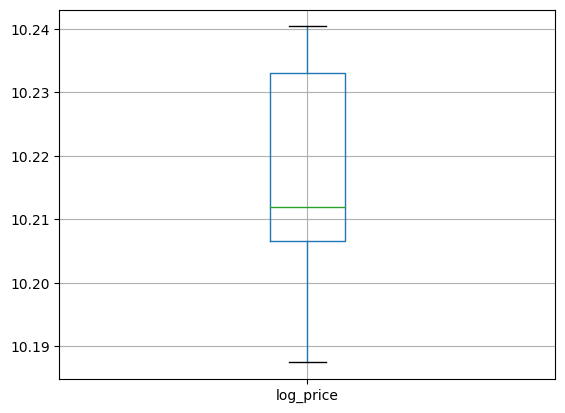

In [81]:
data[['log_price']].boxplot();
plt.show()

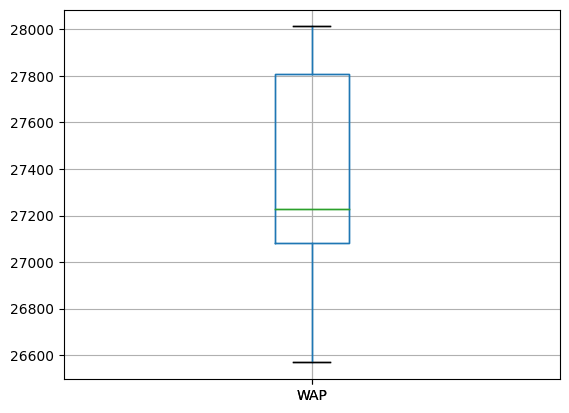

In [83]:
data[['WAP']].boxplot();
plt.show()

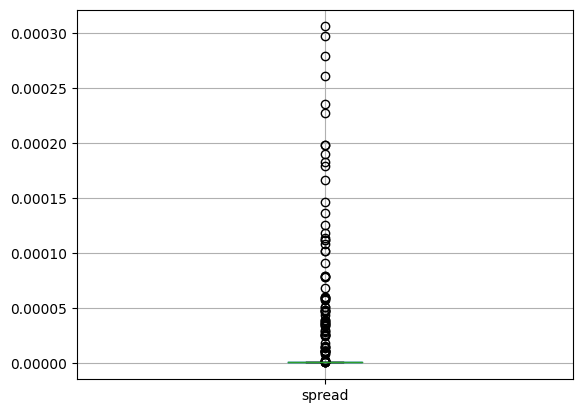

In [84]:
data[['spread']].boxplot();
plt.show()

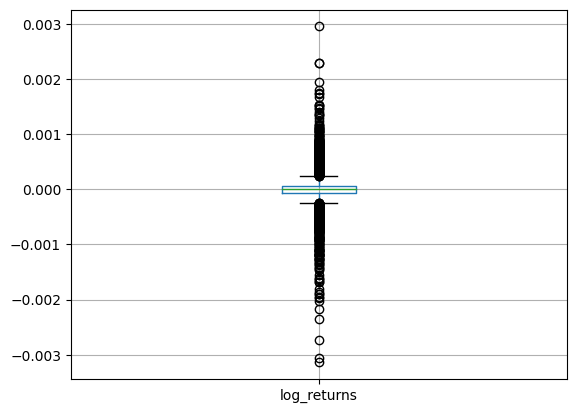

In [89]:
data[['log_returns']].boxplot();
plt.show()

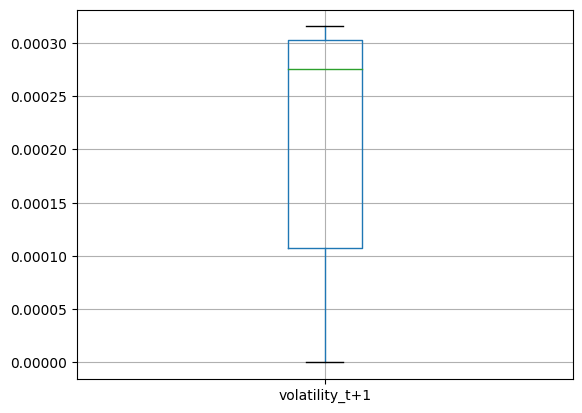

In [90]:
data[['volatility_t+1']].boxplot();
plt.show()

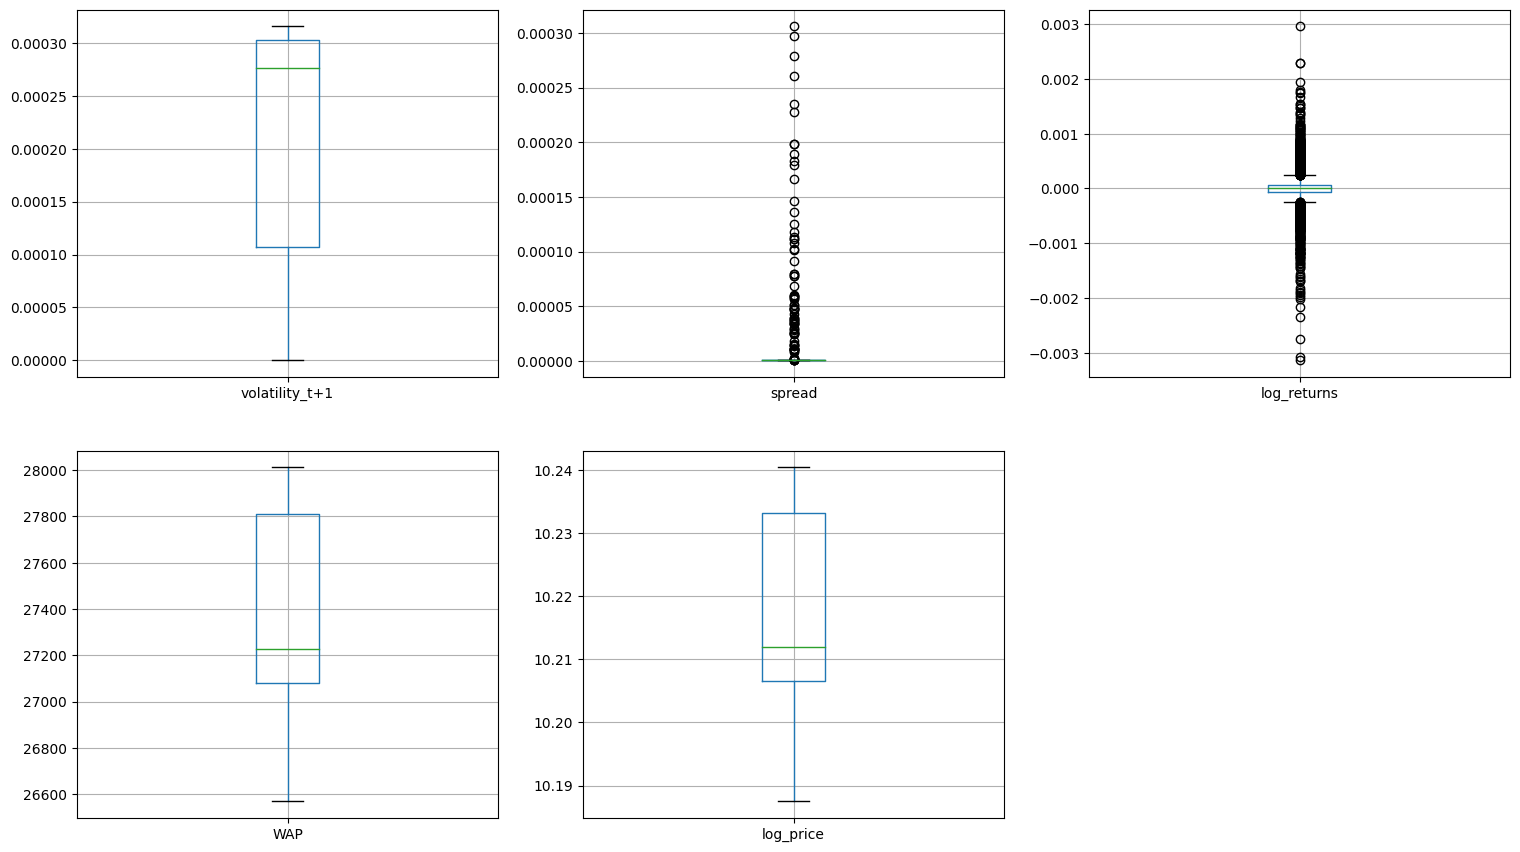

In [107]:
## All in one 
plt.subplot(2, 3, 1)
data[['volatility_t+1']].boxplot()

plt.subplot(2, 3, 2)
data[['spread']].boxplot()

plt.subplot(2, 3, 3)
data[['log_returns']].boxplot()

plt.subplot(2, 3, 4)
data[['WAP']].boxplot()

plt.subplot(2, 3, 5)
data[['log_price']].boxplot()

# x = np.array([0, 1, 2, 3])
# y = np.array([10, 20, 30, 40])

# plt.subplot(2, 3, 6)
# plt.plot(x,y)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# figure(figsize=(150, 150), dpi=300)

plt.show()

# Scaling Data

In [108]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,10.236571,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000,12.61820,2.61279,0.656911
2023-03-27 10:30:41,10.236571,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000,13.06140,3.30068,0.596545
2023-03-27 10:30:45,10.236710,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069,10.22098,5.38172,0.310155
2023-03-27 10:30:50,10.236710,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065,9.73054,5.83722,0.250089
2023-03-27 10:30:54,10.236710,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060,0.23012,6.32311,-0.929769


In [113]:
# MinMaxScaler (Normalizing): each feature will be in a fixed range in [0,1] & preserve matrix sparsity

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
df

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 19:54:46,0.354159,0.999455,0.348817,0.096719,0.348846,0.000273,0.347526,0.201124,0.347547,0.035712,0.348123,0.000041,0.514777,0.869490,0.096762,0.152350,0.512196
2023-03-27 19:54:51,0.354166,0.999498,0.348817,0.025913,0.348846,0.000273,0.347526,0.334725,0.347588,0.035328,0.348130,0.000041,0.514819,0.869430,0.025959,0.234191,0.154878
2023-03-27 19:54:56,0.351217,0.999673,0.345904,0.009905,0.345829,0.045158,0.344607,0.482708,0.344628,0.015520,0.345204,0.000041,0.489173,0.869389,0.019272,0.309267,0.093395


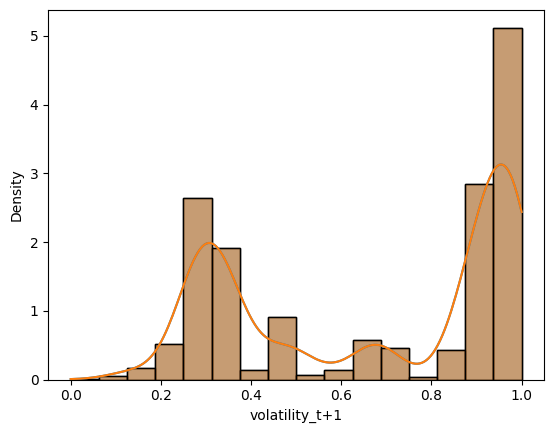

In [117]:
sns.histplot(df['volatility_t+1'], kde = True, stat='density');
plt.show()

Temporary Classification

- Above 0.75 -> high
- Between 0.65 & 0.75 -> medium
- Less than 0.65 -> low

In [119]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071


In [155]:
y = y.set_index(data['scrape_time'])

In [164]:
df['realized_volatility'] = y['realized_volatility']

In [165]:
df

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI,realized_volatility
scrape_time,,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490,0.000000
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303,0.000000
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094,0.000000
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058,0.000069
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071,0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 19:54:46,0.354159,0.999455,0.348817,0.096719,0.348846,0.000273,0.347526,0.201124,0.347547,0.035712,0.348123,0.000041,0.514777,0.869490,0.096762,0.152350,0.512196,0.000274
2023-03-27 19:54:51,0.354166,0.999498,0.348817,0.025913,0.348846,0.000273,0.347526,0.334725,0.347588,0.035328,0.348130,0.000041,0.514819,0.869430,0.025959,0.234191,0.154878,0.000274
2023-03-27 19:54:56,0.351217,0.999673,0.345904,0.009905,0.345829,0.045158,0.344607,0.482708,0.344628,0.015520,0.345204,0.000041,0.489173,0.869389,0.019272,0.309267,0.093395,0.000274


In [167]:
# df['volatility_levels'] = pd.cut(x = df['realized_volatility'],
#                        bins=[df['realized_volatility'].min()-1,
#                              np.percentile(df['realized_volatility'], 25),
#                              np.percentile(df['realized_volatility'], 50),
#                              np.percentile(df['realized_volatility'],75),
#                              df['realized_volatility'].max()+1], 
#                        labels=['low', 'medium','high'])

In [170]:
np.percentile(df['volatility_t+1'], 25), np.percentile(df['volatility_t+1'], 50), np.percentile(df['volatility_t+1'],75),

(0.34060535493594907, 0.8740633965930373, 0.9595653044630515)

Temporary Classification 

- Above 0.75 -> high
- Between 0.65 & 0.75 -> medium
- Less than 0.65 -> low

# Models

Let Baseline be predicting the previous value.

List of methods to try:
- ARIMA Time Series ✅ 
- RNN
- LSTM

## Baseline Model  ✅

In [198]:
df_vol= df['volatility_t+1'].to_frame()

In [200]:
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*df_vol.shape[0])

df_train = df_vol.iloc[:index]
df_test = df_vol.iloc[index:]

In [201]:
y_pred = df_test.shift(1)
y_pred

,volatility_t+1
scrape_time,
2023-03-27 16:12:18,NaN
2023-03-27 16:12:23,0.996080
2023-03-27 16:12:27,0.995972
2023-03-27 16:12:33,0.995858
2023-03-27 16:12:38,0.995939
...,...
2023-03-27 19:54:46,0.869550
2023-03-27 19:54:51,0.869490
2023-03-27 19:54:56,0.869430


In [202]:
y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]

print(f"R2: {r2_score(y_true, y_pred)}")

R2: 0.8615538391630807


## Linear Regression on Time Series  ✅

In [204]:
df2 = df.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['volatility_t+1'].shift(i)
    df2_test[f't - {i}'] = df_test['volatility_t+1'].shift(i)

df2_train.dropna(inplace=True)
df2_test.dropna(inplace=True)

df2_train.head()

,volatility_t+1,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
scrape_time,,,,,,,,,,,,,
2023-03-27 10:31:33,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483,0.000000,0.000000
2023-03-27 10:31:38,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483,0.000000
2023-03-27 10:31:42,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483
2023-03-27 10:31:47,0.160307,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057
2023-03-27 10:31:51,0.155851,0.160307,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057


In [206]:
# Train Test Split
X2_train = df2_train.drop(columns = ['volatility_t+1'])
y2_train = df2_train['volatility_t+1']
X2_test = df2_test.drop(columns = ['volatility_t+1'])
y2_test = df2_test['volatility_t+1']

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(4346, 12) (4346,) (2893, 12) (2893,)


In [209]:
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

R2:  0.8606333122223265


## ARIMA Time Series ✅

FYI
What is ARIMA: https://medium.com/@pavanmeduri1_55193/time-series-forecasting-arima-model-d1e0c38770c0

👉 Example: ARIMA models recursively predict the next data points one after the other

### ARIMA data processing 

We don't need to additive decomposition nor multiplicative decomposition here since each volatility is not accumulative.

In [305]:
y_arima = df_vol.reset_index()["volatility_t+1"][2:-1]

In [306]:
##### Ensure stationarity ########
from statsmodels.tsa.stattools import adfuller

adfuller(y_arima)[1]  # p-value

0.14835862802530692

ADF tests the following precedure:

- The p-value should be less than 0.05 to have a 95% confidence in the stationarity.

- If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").



Steps:

1. Convert a non-stationary TS to stationary

2. Forecast stationary TS by extrapolating stationary properties

3. Reintroduce seasonality and the rest

In [307]:
differenced_1 = y_arima.diff().dropna()
differenced_2 = differenced_1.diff().dropna()

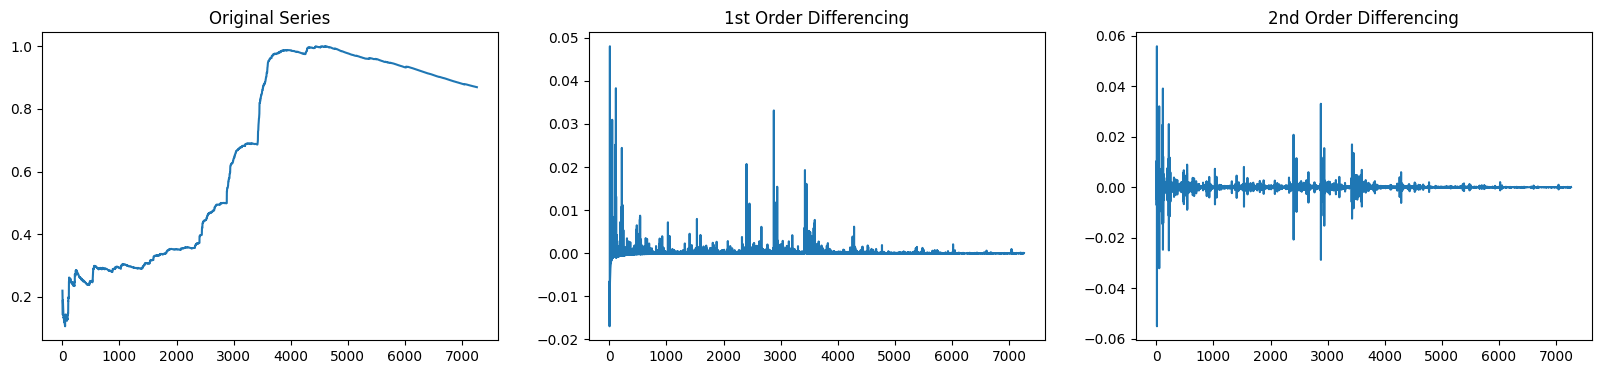

In [308]:
zero_diff = y_arima
first_order_diff = differenced_1
second_order_diff = differenced_2


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');
plt.show()

### Auto-ARIMA (mape:0.1)

#### Autocorrelation(q) and Partial Autocorrelation(p)

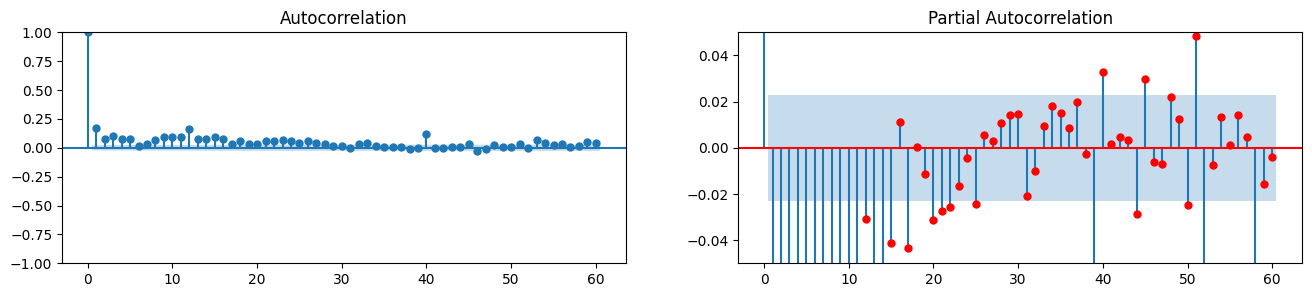

In [315]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(differenced_1, lags=60, ax=axes[0])

plot_pacf(differenced_2, lags=60, ax=axes[1], color='r');
plt.ylim(-0.05, 0.05)
plt.show()

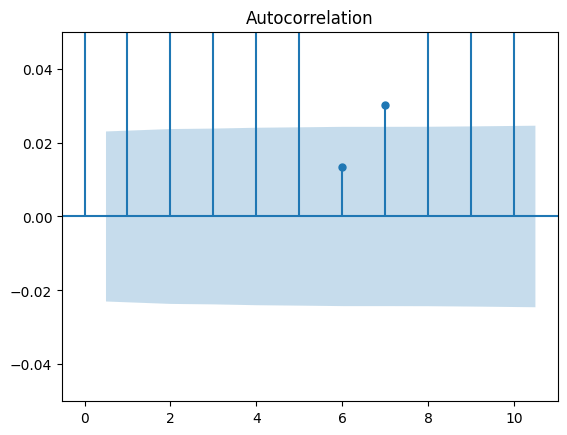

In [327]:
plot_acf(differenced_1, lags=10);
plt.ylim(-0.05, 0.05)
plt.show()
# q = 5

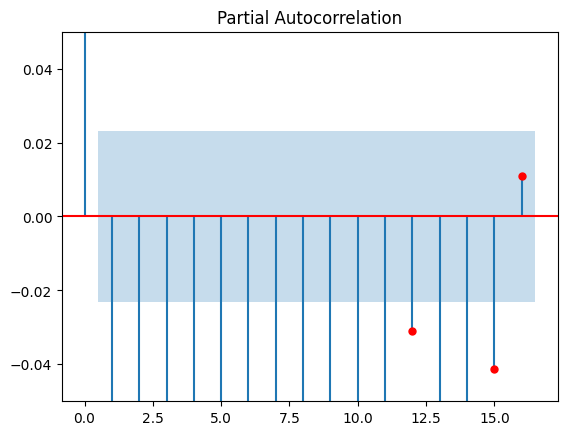

In [324]:
plot_pacf(differenced_2, lags=16, color='r');
plt.ylim(-0.05, 0.05)
plt.show()

# p = 14

In [336]:
## p,d,q
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(y_arima, order=(5, 1, 10), trend='t')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         volatility_t+1   No. Observations:                 7260
Model:                ARIMA(5, 1, 10)   Log Likelihood               37669.850
Date:                Tue, 28 Mar 2023   AIC                         -75305.700
Time:                        18:42:38   BIC                         -75188.570
Sample:                             0   HQIC                        -75265.413
                               - 7260                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.387e-05   4.74e-05      1.771      0.077   -8.97e-06       0.000
ar.L1          0.2221      0.005     48.917      0.000       0.213       0.231
ar.L2          0.2383      0.006     39.408      0.000       0.226       0.250
ar.L3          0.4916      0.006     85.870      0.000       0.480       0.503
ar.L4          0.0217      0.005      4.308      0.000       0.012       0.032
ar.L5         -0.1522      0.007    -22.517      0.000      -0.165      -0.139
ma.L1         -0.0630      0.005    -12.935      0.000      -0.073      -0.053
ma.L2         -0.2401      0.007    -35.920      0.000      -0.253      -0.227
ma.L3         -0.4551      0.007    -63.806      0.000      -0.469      -0.441
ma.L4         -0.0484      0.007     -6.595      0.000      -0.063      -0.034
ma.L5          0.1551      0.009     17.303      0.000       0.138       0.173
ma.L6         -0.0288      0.007     -4.068      0.000      -0.043      -0.015
ma.L7         -0.0242      0.007     -3.695      0.000      -0.037      -0.011
ma.L8         -0.0254      0.010     -2.623      0.009      -0.044      -0.006
ma.L9          0.0328      0.006      5.138      0.000       0.020       0.045
ma.L10         0.0416      0.006      6.968      0.000       0.030       0.053
sigma2      1.807e-06   4.54e-09    398.091      0.000     1.8e-06    1.82e-06
===================================================================================
Ljung-Box (L1) (Q):                   4.31   Jarque-Bera (JB):          80770711.01
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            17.65
Prob(H) (two-sided):                  0.00   Kurtosis:                       518.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.12e+17. Standard errors may be unstable.
"""

#### Forcasting plots (Evaluate model performance)

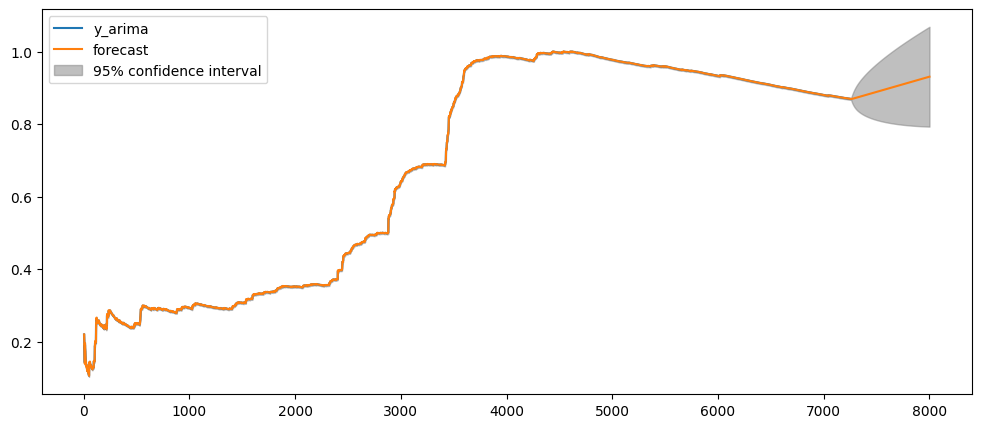

In [340]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y_arima, label='y_arima');
plot_predict(arima, start=1, end=8000, ax=axs);

plt.show()

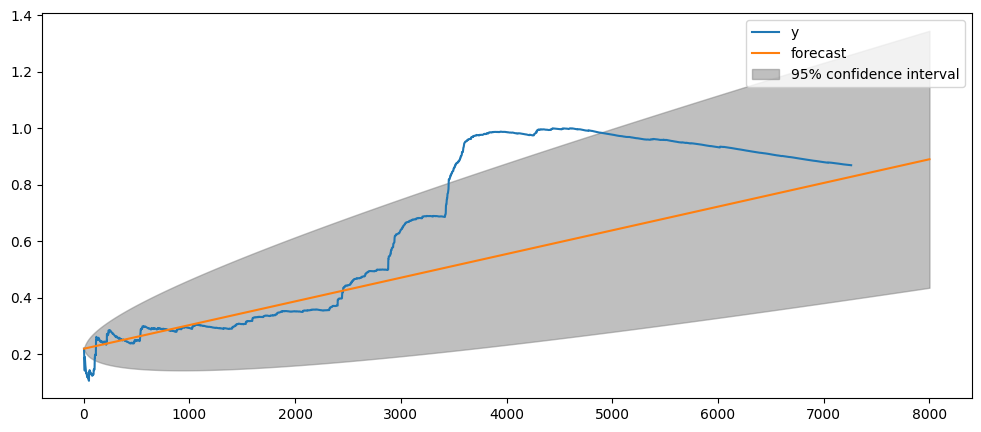

In [343]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y_arima, label='y')
plot_predict(arima, start=1, end=8000, ax=axs, dynamic=True);
plt.show()

#### Out-of-Sample Forecasts (real "future")

In [347]:
y_arima = y_arima.reset_index()

In [349]:
y = y_arima['volatility_t+1']

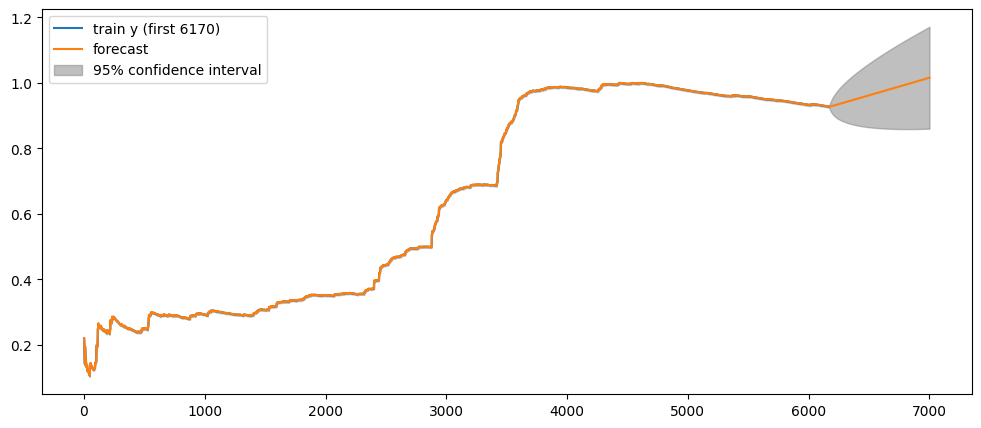

In [374]:
train = y[0:6170]
test = y[6170:]

arima2 = ARIMA(train, order=(5, 1, 10), trend='t')
arima2 = arima2.fit()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train, label='train y (first 6170)')
plot_predict(arima2, start=1, end=7000, ax=axs, dynamic=False);
plt.show()

In [375]:
forecast_results = arima2.get_forecast(len(test), alpha=0.05)

## Here are the forcasts
forecast_train = forecast_results.predicted_mean

## Here are the confidence intervals
confidence_int = forecast_results.conf_int().values

In [376]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

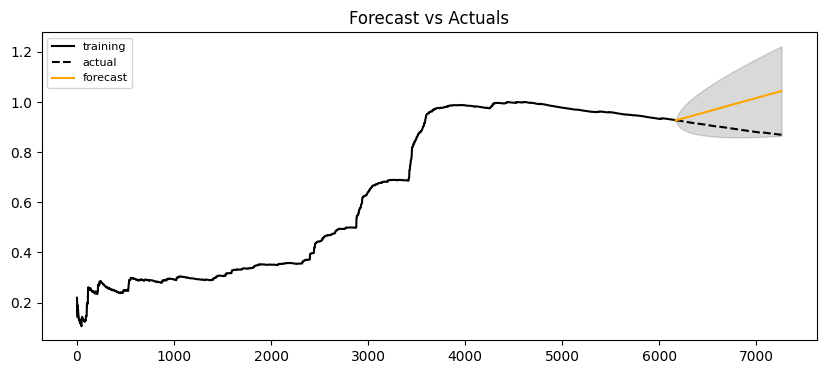

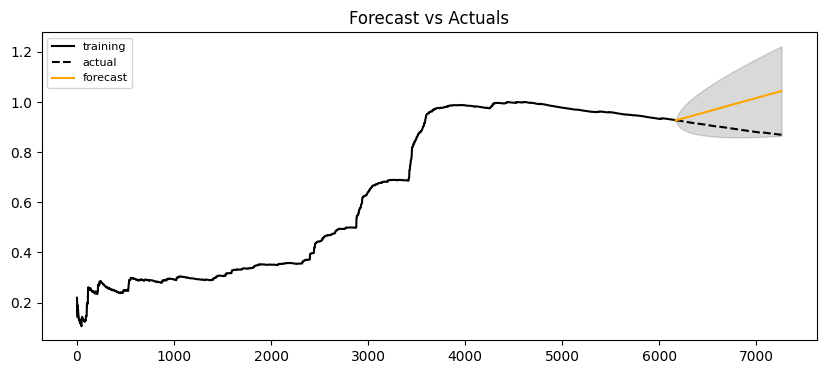

In [378]:
plot_forecast(forecast_train, train, test, confidence_int[:,0], confidence_int[:,1])
plt.show()

#### Condition for inference

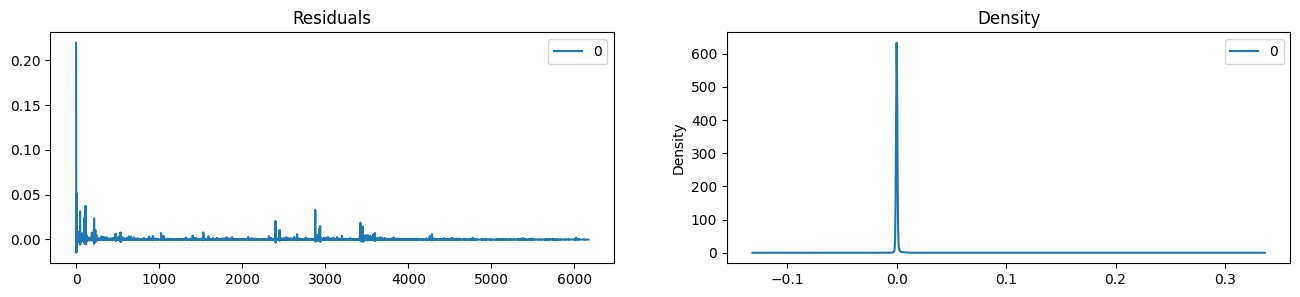

In [379]:
residuals = pd.DataFrame(arima2.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);
plt.show()

#### Cross-validation perfromance matrics

In [382]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [383]:
forecast_accuracy(forecast_train, test)

{'mape': 0.09992800978516414,
 'me': 0.08861209421815305,
 'mae': 0.08861209421815305,
 'mpe': 0.09992800978516414,
 'rmse': 0.102087480133344,
 'acf1': 0.9972836417074067,
 'corr': -0.9987079501490795,
 'minmax': 0.0882766644398264}

#### Grid Search for further improvements

In [388]:
model = pm.auto_arima(
    train, 
    start_p=0, max_p=3,
    start_q=0, max_q=3, 
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())
## optimal is (0,2,3)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62659.075, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62835.645, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62816.826, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62625.393, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62847.441, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62888.482, Time=1.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62883.497, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-62840.424, Time=1.32 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-62872.245, Time=0.53 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 7.079 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6170
Model:               SARIMAX(3, 1, 0)   Log Likelihood               31449.241
Date:                Tue, 28 Ma

The best model suggested here is ARMIA (3,1,0) (0,0,0) [0] intercept

#### Attempt with the suggested params

The best model suggested here is ARMIA (3,1,0) (0,0,0) [0] intercept

/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


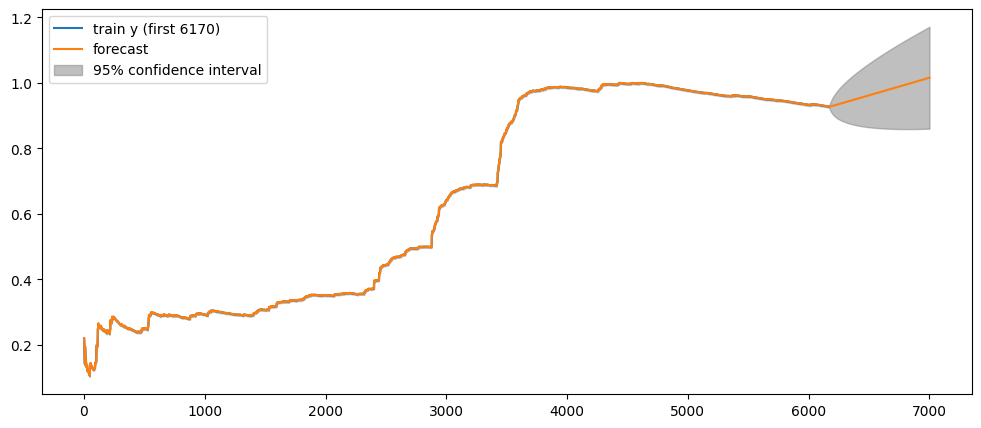

In [396]:
train = y[0:6170]
test = y[6170:]

arima3 = ARIMA(train, order=(3, 1, 0), trend='t')
arima3 = arima3.fit()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train, label='train y (first 6170)')
plot_predict(arima2, start=1, end=7000, ax=axs, dynamic=False);
plt.show()

In [397]:
forecast_results = arima3.get_forecast(len(test), alpha=0.05)

## Here are the forcasts
forecast_train = forecast_results.predicted_mean

## Here are the confidence intervals
confidence_int = forecast_results.conf_int().values

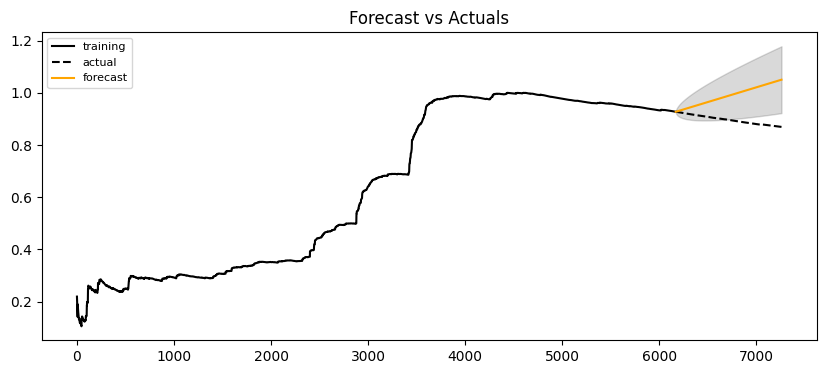

In [398]:
plot_forecast(forecast_train, train, test, confidence_int[:,0], confidence_int[:,1])
plt.show()

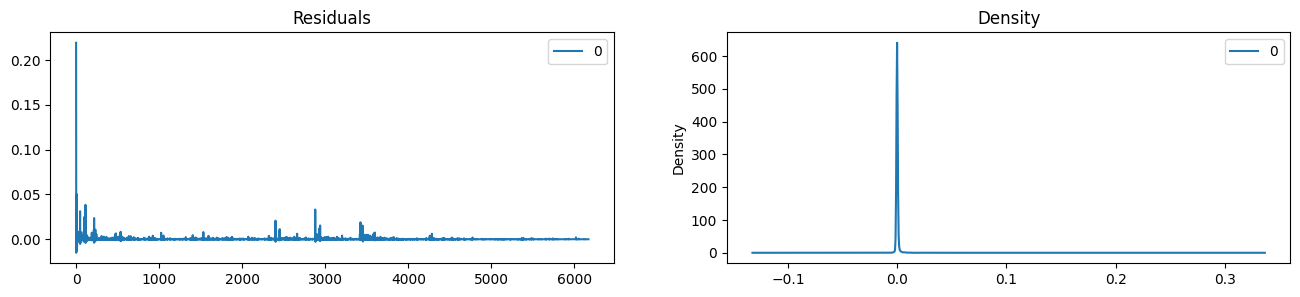

In [399]:
residuals = pd.DataFrame(arima3.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);
plt.show()

In [400]:
forecast_accuracy(forecast_train, test)

{'mape': 0.10393559272635704,
 'me': 0.09217272798828029,
 'mae': 0.09217272798828029,
 'mpe': 0.10393559272635704,
 'rmse': 0.10600693084028967,
 'acf1': 0.9972635973200906,
 'corr': -0.9987247987392772,
 'minmax': 0.09143280605237325}

### Boosted-Linear Auto-ARIMA (mape:0.047) 

Source: https://towardsdatascience.com/gradient-boosted-arima-for-time-series-forecasting-e093f80772f6

ThymeBoost: https://github.com/tblume1992/ThymeBoost

In [490]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train,
                            trend_estimator=['linear', 'arima'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test))
tb_mae = np.mean(np.abs(test - predicted_output['predictions']))
tb_rmse = (np.mean((test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test)) / (np.sum((np.abs(test))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.09694846538052182
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.01240948787199412
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 3.6970097191897893e-06
Boosting Terminated 
Using round 3


In [520]:
boosted_model2 = tb.ThymeBoost(verbose=0,
                           split_strategy='gradient')
output2 = boosted_model2.fit(train,
                           min_sample_pct=.2,
                           trend_estimator=['linear'],
                           additive = False,
                            seasonal_estimator='fourier',
                           seasonal_period=2500,
                           global_cost='maicc',
                           fit_type=['global', 'local'],
                           )
predicted_output2 = boosted_model2.predict(output2, len(test))

In [ ]:
boosted_mode3 = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train,
                            trend_estimator=['smoother'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test))
tb_mae = np.mean(np.abs(test - predicted_output['predictions']))
tb_rmse = (np.mean((test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test)) / (np.sum((np.abs(test))))

In [ ]:
tb_mape, tb_mae, tb_rmse, 

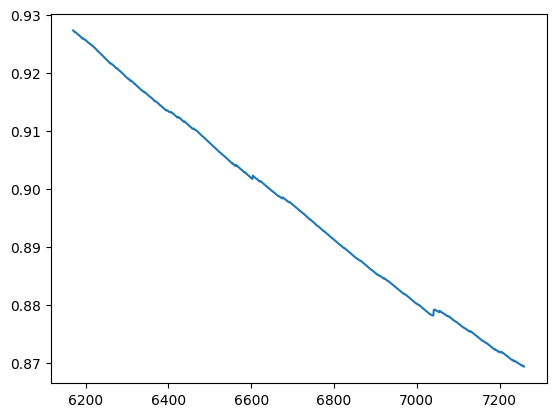

In [500]:
plt.plot(test)
plt.show()

In [406]:
tb_mape, tb_mae, tb_rmse, 

(0.004742652647796939, 0.004252360467151375, 0.005463235452542654)

In [509]:
# import sklearn.metrics as metrics
# def regression_results(y_true, y_pred):
#     # Regression metrics
#     explained_variance=metrics.explained_variance_score(y_true, y_pred)
#     mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
#     mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
#     median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
#     r2=metrics.r2_score(y_true, y_pred)
#     print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
#     print('r2: ', round(r2,4))
#     print('MAE: ', round(mean_absolute_error,4))
#     print('MSE: ', round(mse,4))
#     print('RMSE: ', round(np.sqrt(mse),4))

In [508]:
# regression_results(test, predicted_output['predictions'])

In [511]:
tb2_mae = np.mean(np.abs(test - predicted_output2['predictions']))
tb2_rmse = (np.mean((test - predicted_output2['predictions'])**2))**.5
tb2_mape = np.sum(np.abs(predicted_output2['predictions'] - test)) / (np.sum((np.abs(test))))

tb2_mape, tb2_mae, tb2_rmse, 

(0.06501758412746872, 0.05829611083615127, 0.06845419445042684)

## Gradient Boosting Random Forest 🚫

## Time series prediction with LSTM in Tensorflow (On Hold)

# Test for overfitting using time split validation

Might not be worth it: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [423]:
train = y[0:6170]
test = y[6170:]

In [424]:
len(train), len(test)

(6170, 1090)

In [452]:
# # Spot Check Algorithms
# models = []
# models.append(('BARIMA', tb.ThymeBoost(verbose=1)))

# # Evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     # TimeSeries Cross validation
#     tscv = TimeSeriesSplit(n_splits=len(train))
    
#     cv_results = cross_val_score(model, train,test, cv=tscv, scoring='r2')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes = [25,50,75,100,250,500,750,1000,1150]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=boosted_model(), X=train, y=test, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
#plt.plot(train_sizes, train_scores_mean, label = 'Training score')
#plt.plot(train_sizes, test_scores_mean, label = 'Test score')
#plt.ylabel('r2 score', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.legend()

In [453]:
# X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
# y_train = data_consumption.loc[:'2016', 'Consumption']
# X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
# y_test = data_consumption.loc['2017', 'Consumption']

In [454]:
# # Spot Check Algorithms
# models = []
# models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# models.append(('KNN', KNeighborsRegressor())) 
# models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
# models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# # Evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     # TimeSeries Cross validation
#     tscv = TimeSeriesSplit(n_splits=10)
    
#     cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

# Random Trials

In [536]:
data

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000,12.61820,2.61279,0.656911
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000,13.06140,3.30068,0.596545
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069,10.22098,5.38172,0.310155
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065,9.73054,5.83722,0.250089
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060,0.23012,6.32311,-0.929769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274,3.94154,3.75387,0.024387
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274,1.05772,5.77021,-0.690178
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274,0.78533,7.61987,-0.813132
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274,1.60109,4.87098,-0.505231
